In [1]:
import numpy as np
import decimal
import matplotlib.pyplot as plt
import scipy.interpolate

In [2]:
BER2D=[]

for i in range(100):
    
    BER_values = []  # To store BER for each SNR
    SNR_range = range(31)  # SNR values from 0 to 30 dB
    decimal.getcontext().prec=20
    for SNRdb in SNR_range:
        K = 64 # number of OFDM subcarriers
        CP = K//4  # length of the cyclic prefix
        P = 8 # number of pilot carriers per OFDM block
        pilotValue = 1+1j # value each pilot transmits
    
        allCarriers = np.arange(K)  # ([0, 1, ... K-1])
        pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier
        pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
        P = P+1
        dataCarriers = np.delete(allCarriers, pilotCarriers)
    
        mu = 2 # bits per symbol
    
        payloadBits_per_OFDM = len(dataCarriers)*mu  #no.of payload bits per OFDM symbol
    
        mapping_table = {
            (0,0) : 1+1j,
            (0,1) : 1-1j,
            (1,1) : -1-1j,
            (1,0) : -1+1j,
        }
    
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b1, b0)
                Q = mapping_table[B]
    
        demapping_table = {v : k for k, v in mapping_table.items()}
    
        channelResponse = np.array([1, 0])  # the impulse response of the wireless channel
        H_exact = np.fft.fft(channelResponse, K)
    
        bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
    
        def SP(bits):
            return bits.reshape((len(dataCarriers), mu))
    
        bits_SP = SP(bits)
    
        def Mapping(bits):
            return np.array([mapping_table[tuple(b)] for b in bits])
        MappedSymbols = Mapping(bits_SP)
    
        def OFDM_symbol(payload):
            symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    
            symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
            symbol[dataCarriers] = payload  # allocate the data carriers    
            return symbol
    
        OFDM_data = OFDM_symbol(MappedSymbols)
    
        def IDFT(OFDM_data):
            return np.fft.ifft(OFDM_data)
    
        OFDM_time = IDFT(OFDM_data)
    
        def addCP(OFDM_time):
            cp = OFDM_time[-CP:]               # take the last CP samples ...
            return np.hstack([cp, OFDM_time])  # ... and add them to the beginning
    
        OFDM_withCP = addCP(OFDM_time)
    
        def channel(signal):
                convolved = np.convolve(signal, channelResponse)
                signal_power = np.mean(abs(convolved**2))
                sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
                noise = np.sqrt(sigma2/2)*(np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape)) # Generate complex noise with given variance
                return convolved + noise
    
        OFDM_TX = OFDM_withCP
        OFDM_RX = channel(OFDM_TX)
    
        def removeCP(signal):
            return signal[CP:(CP+K)]
        OFDM_RX_noCP = removeCP(OFDM_RX)
    
        def DFT(OFDM_RX):
            return np.fft.fft(OFDM_RX)
        OFDM_demod = DFT(OFDM_RX_noCP)
    
        def channelEstimate(OFDM_demod):
            pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
            Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
            Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
            Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
            Hest = Hest_abs * np.exp(1j*Hest_phase)
            return Hest
        Hest = channelEstimate(OFDM_demod)
    
        def Demapping(QAM):
            # array of possible constellation points
            constellation = np.array([x for x in demapping_table.keys()])
    
            # calculate distance of each RX point to each possible point
            dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
            # for each element in QAM, choose the index in constellation 
            # that belongs to the nearest constellation point
            const_index = dists.argmin(axis=1)
    
            # get back the real constellation point
            hardDecision = constellation[const_index]
    
            # transform the constellation point into the bit groups
            return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision
    
        PS_est, hardDecision = Demapping(OFDM_demod)
    
        def PS(bits):
            return bits.reshape((-1,))
        bits_est = PS(PS_est)
    
        indices_to_remove = []
        for i in range(0, len(bits_est), 16):
            indices_to_remove.append(i)       # Remove the i-th index (0, 16, 32, ...)
            indices_to_remove.append(i + 1)   # Remove the (i+1)-th index (1, 17, 33, ...)
    
        # Use np.delete to remove those indices from bits_est
        databits_est = np.delete(bits_est, indices_to_remove)
    
        count=0
        for i in range(len(bits)):
            if(bits[i]!=databits_est[i]):
                count=count+1
                
        decimal.getcontext().prec=40

        BER=decimal.Decimal(count/len(bits))
        #print("BER is: "+str(BER))
        
        BER_values.append(BER)

    BER2D.append(BER_values)

In [3]:
BERarr = np.array(BER2D)

In [4]:
col_means = np.mean(BERarr, axis=0)
print("Mean BER:", col_means)

Mean BER: [Decimal('0.1558181818181818149154915786880337691404')
 Decimal('0.1238181818181818151514139714208795339802')
 Decimal('0.106090909090909088288712247560852119932')
 Decimal('0.07954545454545454381128921639287909783884')
 Decimal('0.05245454545454545276089719507695008360307')
 Decimal('0.03481818181818181676817625103126374597187')
 Decimal('0.02236363636363636272358368373147641250396')
 Decimal('0.01254545454545454487987887759459226799662')
 Decimal('0.006909090909090908755318949374668591190126')
 Decimal('0.001818181818181818093504986677544366102663')
 Decimal('0.0007272727272727272374019946710177464410664')
 Decimal('0.0003636363636363636187009973355088732205332') Decimal('0')
 Decimal('0') Decimal('0') Decimal('0') Decimal('0') Decimal('0')
 Decimal('0') Decimal('0') Decimal('0') Decimal('0') Decimal('0')
 Decimal('0') Decimal('0') Decimal('0') Decimal('0') Decimal('0')
 Decimal('0') Decimal('0') Decimal('0')]


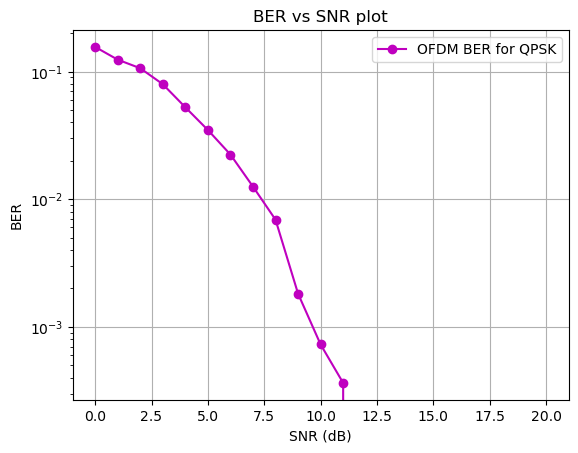

In [5]:
# Plotting the BER vs SNR
plt.figure()
plt.semilogy(SNR_range, col_means, 'm-o', label='OFDM BER for QPSK')
plt.title('BER vs SNR plot')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.xlim(-1,21)
plt.grid(True)
plt.legend()
plt.show()

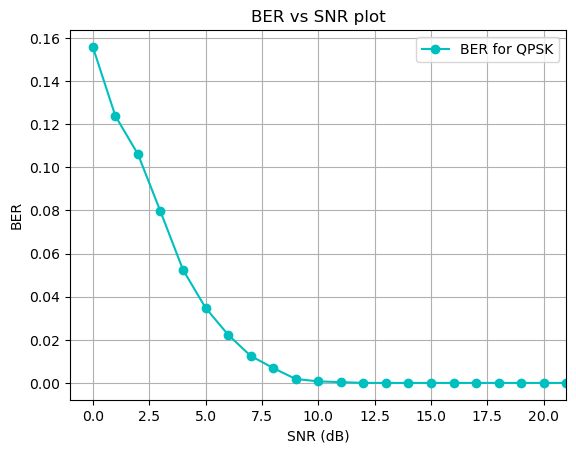

In [6]:
# Plotting the BER vs SNR
plt.figure()
plt.plot(SNR_range, col_means, 'c-o', label='BER for QPSK')
plt.title('BER vs SNR plot')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.xlim(-1,21)
plt.grid(True)
plt.legend()
plt.show()